In [80]:
import textract
import pandas as pd
import os
import json
from gensim.models.phrases import Phrases, Phraser
import nltk
import numpy as np
from gensim.models import word2vec

In [81]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.switch_backend('agg')

In [82]:
resume_folder_path = '/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/SkillMapping/data/Eximius Employees Resumes PDF Format'
skillsheet_file_path = '/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/SkillMapping/data/Key Word Search.xlsx'

In [83]:
skill_sheet = pd.read_excel(skillsheet_file_path, header=[1, 2], dtype=str)
skill_sheet = skill_sheet.drop(skill_sheet.columns[0], axis=1)

In [84]:
skills_dict = {}
all_skills = []
for label, label_data in skill_sheet.iteritems():
    skills_dict[label] = label_data.dropna()
    all_skills.extend(label_data.dropna().tolist())

In [85]:
all_resume_data = []
all_resume_string = []
cnt = 0
for each_file in os.listdir(resume_folder_path):
    each_resume_dict = {}
    each_file_path = os.path.join(resume_folder_path, each_file)
#     stop_words = ['a', 'an', 'the', 'with', 'is', 'by', 'of', 'to', 'in', 'on', 'for', 'from', '&', 'and']
    each_file_str = textract.process(each_file_path, encoding='ascii').decode()
    each_resume_dict['Filename'] = each_file
    each_resume_dict['ResumeString'] = each_file_str
    skills_found = [each_skill.strip() for each_skill in all_skills if each_skill.strip() in each_file_str]
    each_resume_dict['SkillsFound'] = list(set(skills_found))
    all_resume_string.append(each_file_str)
    all_resume_data.append(each_resume_dict)
    cnt += 1

In [86]:
def generating_bigrams(all_resume_string):
    
    stop_words = ['a', 'an', 'the', 'with', 'is', 'by', 'of', 'to', 'in', 'on', 'for', 'from', '&', 'and', 'as']
    bigrams_input = []
    for each_row in all_resume_string:
        preprocessed_words_list = []
        for each_word in each_row.split():
            if each_word not in stop_words:
                preprocessed_words_list.append(each_word)
        bigrams_input.append(preprocessed_words_list)
                
    
    
#     bigrams_input = [each_row.split() for each_row in all_resume_string]
    bigram_transformer = Phrases(bigrams_input, min_count=5, threshold=10)
    bigram_transformer.save("bigrams", pickle_protocol=4)

    fd = open("bigrams.txt", 'a')
    for phrase, score in bigram_transformer.export_phrases(bigrams_input):
        fd.write(u'{0}   {1}'.format(phrase, score))
    fd.close()

    return bigram_transformer, bigrams_input

In [87]:
bigram_transformer, preprocessed_input = generating_bigrams(all_resume_string)

In [88]:
phraser= Phraser(bigram_transformer)

In [89]:
def bigrams_text2input(phraser, preprocessed_input):
    word2vec_input = []
    for f in preprocessed_input:
#         line = [word for word in phraser[f.split()]]
        line = [word for word in phraser[f]]
        word2vec_input.append(line)
    return word2vec_input

In [90]:
word2vec_input = bigrams_text2input(phraser, preprocessed_input)

In [91]:
def tsne_plot_all(model):
    "Creates and TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('tsne_all_words.png')

In [92]:
# tsne_plot_all(model)

In [93]:
def plot_most_common(model, num=20):
    "Creates and TSNE model and plot it"
    labels = []
    tokens = []
    
    for word, obj in nltk.FreqDist(model.wv.vocab).most_common(num):
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('tsne_most_common_words_'+str(num)+'.png')

In [94]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    print('len of similar words', len(close_words))
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.savefig('tsne_most_similar_to_'+word+'.png')
#     plt.show()


In [95]:
model1 = word2vec.Word2Vec(word2vec_input, size=100, window=20, min_count=25, workers=4)

In [96]:
model2 = word2vec.Word2Vec(word2vec_input, min_count=5, sg=0)

In [97]:
print(model1.similarity('C', 'Python'))

0.9868736


/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [98]:
print(model2.similarity('C', 'Python'))

0.9999472


/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


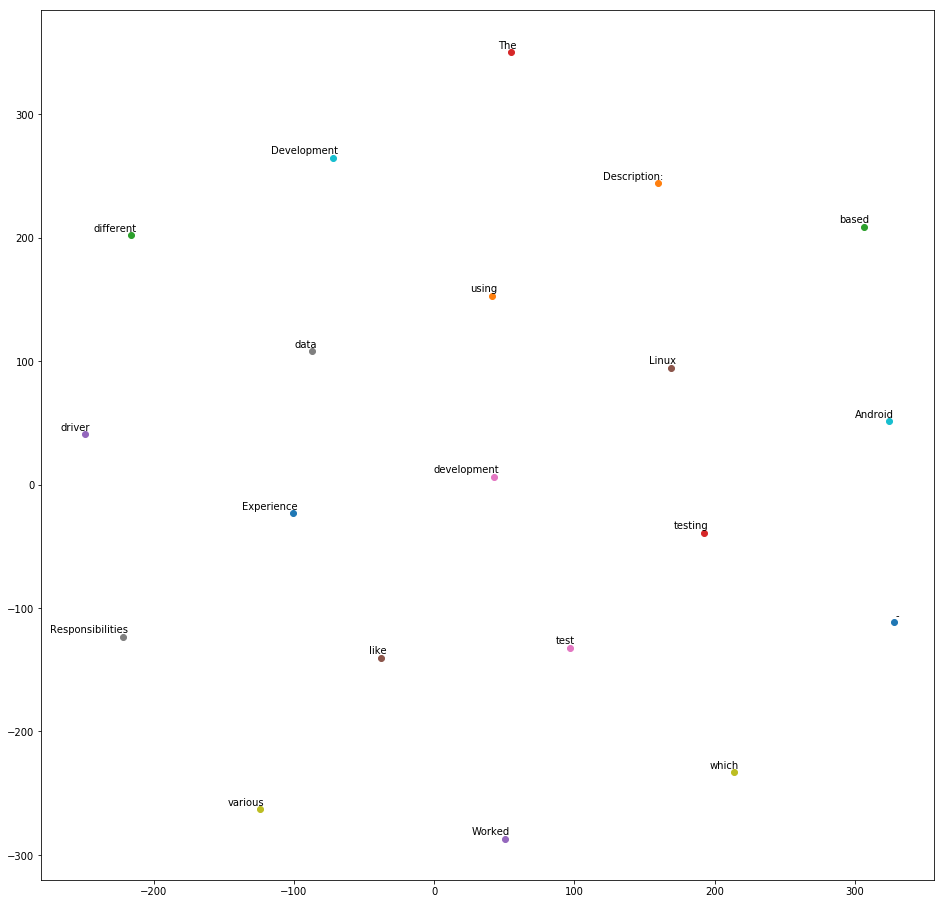

In [99]:
plot_most_common(model1)

/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


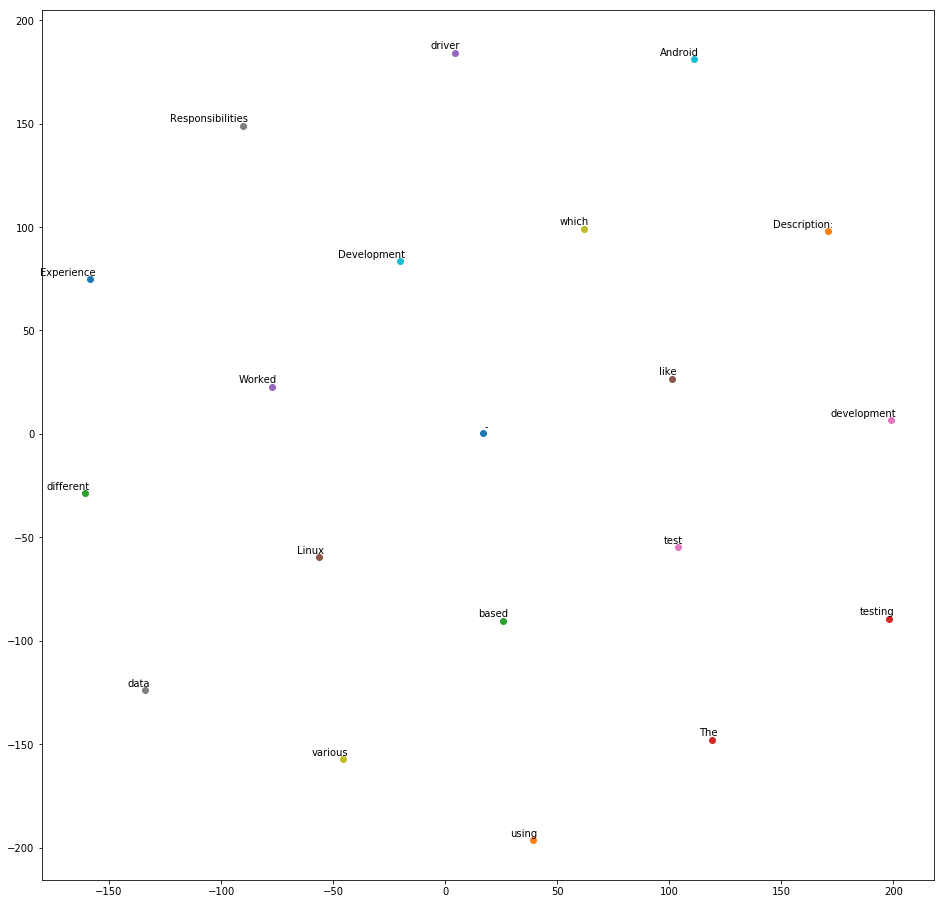

In [100]:
plot_most_common(model2)

/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


len of similar words 10


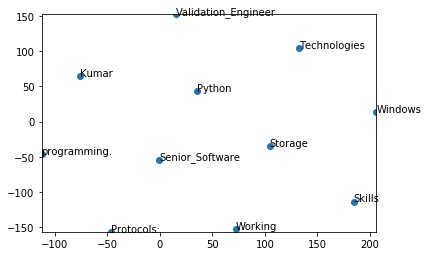

In [101]:
display_closestwords_tsnescatterplot(model1, 'Python')

/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


len of similar words 10


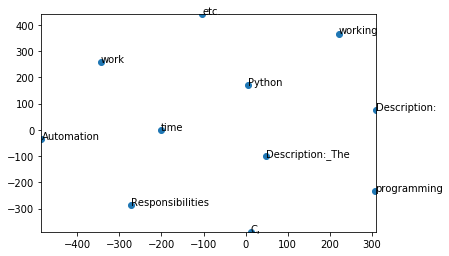

In [102]:
display_closestwords_tsnescatterplot(model2, 'Python')

In [103]:
close_words = model1.similar_by_word('C')
print(close_words)

[('Linux_Kernel', 0.9997404217720032), ('UART,', 0.9996520280838013), ('programming,', 0.9995768070220947), ('Keil', 0.9995458126068115), ('Kernel', 0.9995160102844238), ('CAN', 0.9994984865188599), ('IDE', 0.9994776844978333), ('Tool', 0.9994513988494873), ('Proficient', 0.9994513392448425), ('IPC', 0.9994468092918396)]


/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


In [104]:
close_words = model2.similar_by_word('C')
print(close_words)

[('ARM', 0.9999604225158691), ('Description:', 0.9999581575393677), ('C,', 0.9999581575393677), ('Development', 0.9999578595161438), ('Tools:', 0.9999575614929199), ('Linux', 0.9999516010284424), ('Python,', 0.9999490976333618), ('Technologies:', 0.9999472498893738), ('Python', 0.9999471306800842), ('Hardware', 0.9999468922615051)]


/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


## K Means Clustering

In [108]:
X = model1[model1.wv.vocab]

/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [116]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

In [118]:
words = list(model.wv.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))

Development_Engineer:2
3.2:1
year:2
experience:2
Software:1
Development:1
Experience_working:1
Core:1
Java:1
Android:1
(Android:0
Framework:1
Recognized:1
key:0
player:1
Team:0
development:0
Application.:1
Experience_developing:2
application:1
project:2
configuration:1
management:1
tool.:1
Skills_Programming:2
Languages::2
C/C++,:2
JAVA:1
Scripting_Languages::0
Python:1
Mobile:0
Technologies::0
IDE::0
Android_Studio:1
Data_Structures,:1
Database::1
SQLite:0
Also:1
Worked:1
Git.:1
Knowledge:2
Summary:1
IPC:1
Android_Framework:0
Components:0
like:0
Activity:0
Manager,:1
System:1
Server,:1
Phone:1
Window:2
Manager.:1
Strong_knowledge:0
Framework.:0
UI:0
creating:0
using:0
Task:0
Strong:0
Optimization:0
Debugging:0
skills.:0
problem:0
analysis:0
solving:0
Able:0
work:0
GIT:0
Experience:0
Google:1
APIs:0
remote:0
data:0
via:0
REST:0
third_party:0
libraries.:1
different:0
architecture:0
pattern:1
integrating:0
Network:0
Analytics:0
SDK:0
Projects:0
Sonim:0
Technology::0
8:0
latest:0
Ultra:0


IndexError: list index out of range

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/home/ayusheea/Documents/ML_VirtualEnvs/ResumeSelectionProject/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is current

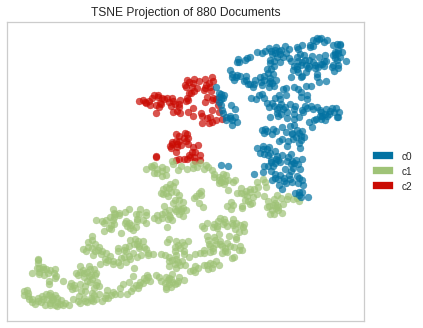

In [124]:
from sklearn.cluster import KMeans
from yellowbrick.text import TSNEVisualizer
clusters = KMeans(n_clusters=3)
clusters.fit(X)

tsne = TSNEVisualizer()
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

In [141]:
assigned_clusters = clusters.predict(X)
words = list(model1.wv.vocab)
word_clusters = {}
for i, word in enumerate(words):
    cluster_val = assigned_clusters[i]
    word_clusters[cluster_val] = word_clusters.get(cluster_val, list())
    print(word_clusters)
    word_clusters[cluster_val].append(word)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [142]:
word_clusters

{2: ['Development_Engineer',
  'experience',
  'Software',
  'Development',
  'Android',
  'Framework',
  'Team',
  'development',
  'Python',
  'Technologies:',
  'Worked',
  'Knowledge',
  'Summary',
  'System',
  'Strong',
  'Experience',
  'Network',
  'Projects',
  '-',
  'years',
  'Firmware',
  'Good_knowledge',
  'at',
  'knowledge',
  'Linux',
  'Python,',
  'Tools',
  'SVN,',
  'Software_Engineer',
  'date',
  'Testing',
  'Test',
  'GIT,',
  'Module',
  'Working',
  'Windows',
  'development.',
  'programming',
  'Bangalore',
  'Ltd',
  'Design',
  'Project',
  'Storage',
  'ARM',
  'C',
  'working',
  'Board',
  'Linux,',
  'Technology',
  'Skills:',
  'o',
  'Technical',
  '2015',
  'Hardware',
  '2013',
  'Kernel',
  'India',
  'Samsung',
  '2010',
  'March',
  'Systems',
  'June',
  'Application',
  'Tools:',
  'Developer',
  'Technologies',
  'Engineering',
  'Embedded',
  'embedded',
  'Skills',
  'GDB,',
  'SPI,',
  'Eximius_Design',
  'Languages:_C,',
  'Product',
  